# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

# functions

## Equal State

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

## PIfunc

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

## Spike_Time_Generator

In [4]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

## activation function

In [5]:
# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# Main

## Set parameters

### CKC's parameters

In [6]:
dt = 0.01

sigma_dict = dict()
sigma_dict['H'] = 1
sigma_dict['C'] = sigma_dict['H']*0.2# RF size of cone cell
dx = sigma_dict['H']/200. #1/sstep
 
#sigma_dict['tau_y'] = 0.01                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

#Width setting
Dynamical_range = 6*sigma_dict['H']/dx #188-16 pixels
hw = 3*Dynamical_range*dx/22 #half bar width  #8 pixels
xlen = 10*sigma_dict['H'] #spatial extend of simulation
tempx = np.arange(0,xlen,dx)

para_dict = {}
para_dict['alpha'] = 40.
para_dict['beta'] = 2.
para_dict['k'] = 40.
para_dict['phi'] = 5.
para_dict['g'] = 2.

para_dict['gramma'] = 100.
para_dict['p'] = 100.
para_dict['psy'] = 0.45

sigma_dict['B'] = sigma_dict['H']*0.2

## LPOU-1D

In [7]:
#main
Tot=300
T=np.arange(dt,Tot,dt)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [8]:
x = LPOU-min(LPOU)
#assign states
x = x.astype(float)
# x = (x-np.mean(x))/np.std(x)
v = ndimage.gaussian_filter1d(x.copy(), sigma=5, order=1, mode='reflect') / dt
# v = findiff.FinDiff(0, dt, acc=4)(x)
xstate, _= EqualState(x, 6)
vstate, _= EqualState(v, 6)

### Feedback and  Feedforward one layer-1D

In [9]:
XOon = 0

In [10]:
y=np.zeros(len(T))
z=np.zeros(len(T))
w=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-para_dict['alpha']*y[j]+para_dict['k']*(x[j]-para_dict['phi']*z[j]))
    dz=dt*(-para_dict['beta']*z[j]+para_dict['g']*y[j])
    dw =(-para_dict['gramma']*w[j]+para_dict['p']*((1-para_dict['psy'])*y[j]-para_dict['psy']*z[j]))*dt    
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz
    w[j+1]=w[j]+dw

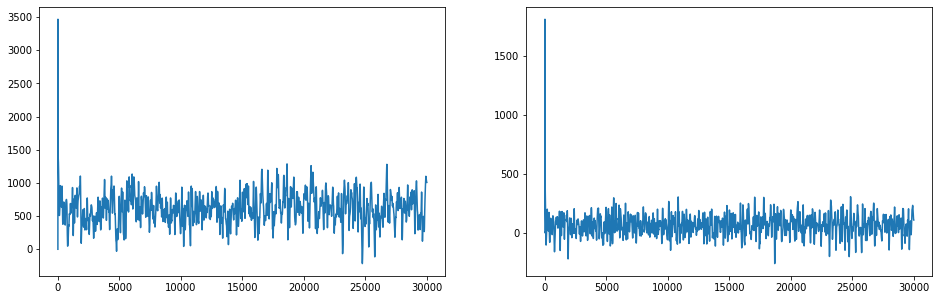

In [11]:
fig, (ax2,ax3) = plt.subplots(nrows=1, ncols=2) 
ax3.plot(w)
ax2.plot(y)
fig.set_size_inches(16,4*(np.sqrt(5)-1))

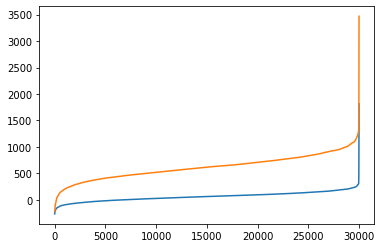

In [12]:
plt.plot(np.sort(w))
plt.plot(np.sort(y))
fig.set_size_inches(8,4*(np.sqrt(5)-1))

### cone

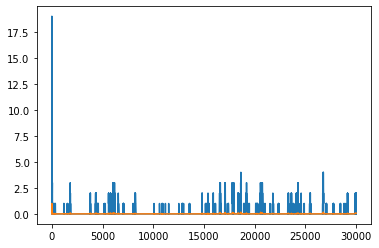

In [13]:
cr = NL(-np.mean(y)+y, 1*np.std(y))
ratio = sum(cr)/Tot/12
cFakeSpike = Spike_Time_Generater(cr/ratio, dt, 10)
crstate,_  = np.histogram(cFakeSpike, np.append(0,T))
plt.plot(crstate)
plt.plot(cr/max(cr))

In [14]:
window = [-1,1] # second
timeshift, cInformation = PIfunc(crstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

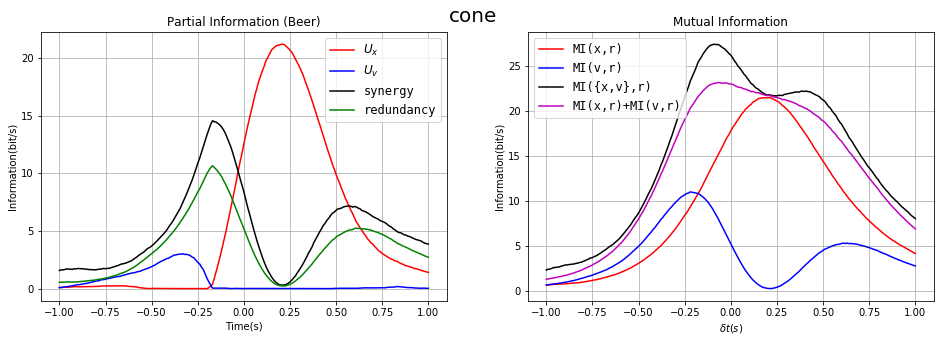

In [15]:
fig, (ax2,ax3) = plt.subplots(nrows=1, ncols=2) 
fig.suptitle('cone', y=0.95, fontsize=20)
ax2.plot(timeshift,cInformation[('Beer','UIx')], 'r-')
ax2.plot(timeshift,cInformation[('Beer','UIv')], 'b-')
ax2.plot(timeshift,cInformation[('Beer','Syn')], 'k-')
ax2.plot(timeshift,cInformation[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,cInformation[('Beer','UIx')]+cInformation[('Beer','Red')], 'r-')
ax3.plot(timeshift,cInformation[('Beer','UIv')]+cInformation[('Beer','Red')], 'b-')
ax3.plot(timeshift,cInformation[('Beer','Syn')]+cInformation[('Beer','Red')]+cInformation[('Beer','UIv')]+cInformation[('Beer','UIx')], 'k-')
ax3.plot(timeshift,2*cInformation[('Beer','Red')]+cInformation[('Beer','UIv')]+cInformation[('Beer','UIx')], 'm-')
ax3.set_title('Mutual Information')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

fig.set_size_inches(16, 4*(np.sqrt(5)-1))

In [16]:
cMIpeaktime = np.round(timeshift[np.argmax(cInformation[('Beer','UIx')]+cInformation[('Beer','Red')])],3)

### bipolar

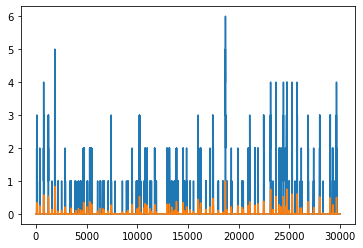

In [17]:
if XOon == 1:
    r = NL(-np.mean(w)+w, 1*np.std(w))
else:
    r = NL(np.mean(w)-w, 1*np.std(w))
ratio = sum(r)/Tot/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate,_  = np.histogram(FakeSpike, np.append(0,T))
plt.plot(rstate)
plt.plot(r/max(r))

In [18]:
window = [-1,1] # second
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

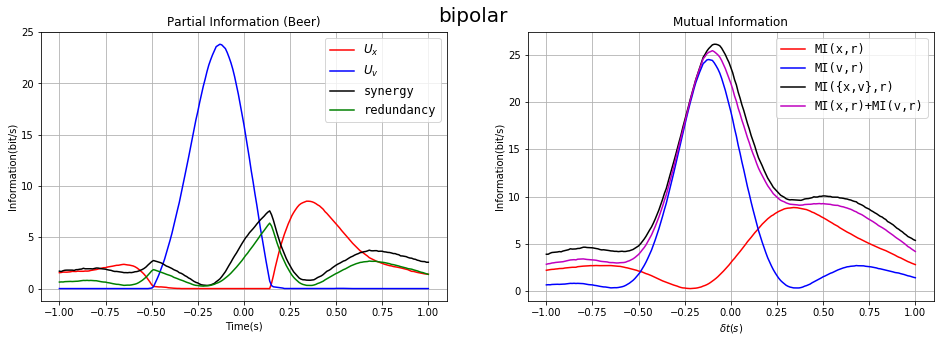

In [19]:
fig, (ax2,ax3) = plt.subplots(nrows=1, ncols=2)
fig.suptitle('bipolar', y=0.95, fontsize=20)
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,Information[('Beer','UIx')]+Information[('Beer','Red')], 'r-')
ax3.plot(timeshift,Information[('Beer','UIv')]+Information[('Beer','Red')], 'b-')
ax3.plot(timeshift,Information[('Beer','Syn')]+Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','UIx')], 'k-')
ax3.plot(timeshift,2*Information[('Beer','Red')]+Information[('Beer','UIv')]+Information[('Beer','UIx')], 'm-')
ax3.set_title('Mutual Information')
ax3.set_xlabel(r'$\delta t(s)$')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

fig.set_size_inches(16, 4*(np.sqrt(5)-1))

In [20]:
np.round(timeshift[np.argmax(Information[('Beer','UIx')]+Information[('Beer','Red')])],3)

0.34

### \Psi vs. MI peak time 

In [21]:
psy_list = np.arange(0.1,1.0,0.03)
offMItabelt = np.zeros(len(psy_list))
offMItabelh = np.zeros(len(psy_list))
onMItabelt = np.zeros(len(psy_list))
onMItabelh = np.zeros(len(psy_list))
for i in range(len(psy_list)):
    para_dict['psy'] = psy_list[i]

    y=np.zeros(len(T))
    z=np.zeros(len(T))
    w=np.zeros(len(T))
    for k in range(len(T)-1):
        dy=dt*(-para_dict['alpha']*y[k]+para_dict['k']*(x[k]-para_dict['phi']*z[k]))
        dz=dt*(-para_dict['beta']*z[k]+para_dict['g']*y[k])
        dw =(-para_dict['gramma']*w[k]+para_dict['p']*((1-para_dict['psy'])*y[k]-para_dict['psy']*z[k]))*dt    
        y[k+1]=y[k]+dy
        z[k+1]=z[k]+dz
        w[k+1]=w[k]+dw



    r = NL(np.mean(w)-w, 1*np.std(w))
    ratio = sum(r)/Tot/3
    FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
    rstate,_  = np.histogram(FakeSpike, np.append(0,T))
    window = [-1,1] # second
    timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
    offMItabelt[i] = np.round(timeshift[np.argmax(Information[('Beer','UIx')]+Information[('Beer','Red')])],3)
    offMItabelh[i] = np.round(max(Information[('Beer','UIx')]+Information[('Beer','Red')]),3)
    
    r = NL(-np.mean(w)+w, 1*np.std(w))
    ratio = sum(r)/Tot/3
    FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
    rstate,_  = np.histogram(FakeSpike, np.append(0,T))
    window = [-1,1] # second
    timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)
    onMItabelt[i] = np.round(timeshift[np.argmax(Information[('Beer','UIx')]+Information[('Beer','Red')])],3)
    onMItabelh[i] = np.round(max(Information[('Beer','UIx')]+Information[('Beer','Red')]),3)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log2
C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered

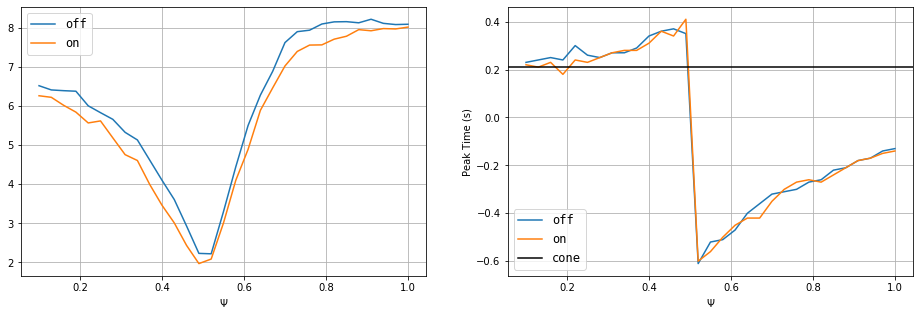

In [22]:
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2)
ax2.plot(psy_list, offMItabelh)
ax3.plot(psy_list, offMItabelt)
ax2.plot(psy_list, onMItabelh)
ax3.plot(psy_list, onMItabelt)
ax3.axhline(cMIpeaktime, c = 'k')

ax3.set_xlabel(r'$\Psi$')
ax3.set_ylabel('Peak Time (s)')
ax2.set_xlabel('Peak Height (bit/s)')
ax2.set_xlabel(r'$\Psi$')
ax2.legend( ('off', 'on') , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( ('off', 'on', 'cone') , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(16, 4*(np.sqrt(5)-1))